In [1]:
#imports
from scipy.spatial import distance_matrix
from random import randrange
import copy
import matplotlib.pyplot as plt
import imageio
import imageio
import random
from time import time
from tqdm import tqdm

In [2]:
#loading datasets 
import numpy as np
kroa={}
krob={}
np_kroa=[]
np_krob=[]
with open('kroa200.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        kroa[x[0]]=(x[1],x[2])
        np_kroa.append((x[1],x[2]))
np_kroa=np.array(np_kroa)
with open('krob200.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        krob[x[0]]=(x[1],x[2])
        np_krob.append((x[1],x[2]))

np_kroa=np.array(np_kroa)
np_krob=np.array(np_krob)

#calculating distance matrix - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html
dista=distance_matrix(np_kroa,np_kroa)
distb=distance_matrix(np_krob,np_krob)

In [3]:
#plotting functions
def plotResult(np_dots, cycles):
    plt.clf()
    plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(dataset[:,0][[*cycles[0],cycles[0][0]]], dataset[:,1][[*cycles[0],cycles[0][0]]], "->")
    plt.plot(dataset[:,0][[*cycles[1],cycles[1][1]]], dataset[:,1][[*cycles[1],cycles[1][1]]], "->")
    
def plotPartResult(np_dots, cycles,i):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.plot(np_dots[:,0], np_dots[:,1], ".")
    plt.savefig(f'plots/{i}.png')
    plt.show()    
def calcDistance(currentCycle, dist):
    distance = 0
    for x,y in zip(currentCycle, [*currentCycle[1:], currentCycle[0]]):
        distance += dist[x][y]
    return distance 

In [4]:
# 3rd variable - Generate neighbour solution
#changes edges internally
def change_edges(cycles, edge1, edge2, internally=False): # dummy internally
    cI= 0 if len(np.where(cycles[0] == edge1)[0])!=0 else 1 
#     print(cycles[cI])
    inA=np.where(cycles[cI] == edge1)[0][0]
    inB=np.where(cycles[cI] == edge2)[0][0]
    inA += 1
    inB += 1
    cycle = cycles[cI]
    cycle[inA: inB] = np.flip(cycle[inA: inB])
    return cycles

In [5]:
#changes vertex internally or externaly between cycles
def change_vertices(cycles, a, b, internally=True):
    if internally:
#         print(len(np.where(cycles[0] == a)))
#         print(np.where(cycles[0] == a))
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI][inB]=tmp
        #print(cycles[0][inB], cycles[0][inA])
    else:
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        cI2 = 1-cI
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI2] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI2][inB]=tmp
        #pass
    #print(cycles)
    return cycles
    #if aIndex in cycles[0]
    #raise NotImplementedError

In [6]:
# 1st variable - Start cycle - with random assignments
def start_cycle_random():
    cycles={}
    cycles[0]=np.random.choice(200,100,replace=False)
    cycles[1]=np.array([i for i in np.arange(0,200,1) if i not in cycles[0]])
    np.random.shuffle(cycles[1])
    return cycles

In [7]:
# 1st variable - Start cycle - with nearest neighbour method
def start_cycle_heuristic(dataset_choice):
    results=[]
    min_result=np.inf
    max_result=0
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)


    #zmiana dystansu przekątnej na nieskonczonosc
    np.fill_diagonal(dist, np.inf)

    cycles={}
    cycles[0]=[randrange(200)]
    cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]

    for b in range(2):
        dist[:,int(cycles[b][0])]=np.inf

    chosenCycle=1
    for i in range(0,198):
        chosenCycle = int((chosenCycle + 1)%2)
        candidates=[]
        for z,index in enumerate(cycles[chosenCycle]):
            candidates.append((np.argmin(dist[index]),np.min(dist[index]),z))
        candidates=np.array(candidates)
        x=np.argmin(candidates[:,1])
        cycles[chosenCycle]=np.insert(cycles[chosenCycle],int(candidates[x,2]),int(candidates[x,0]))
        dist[:,int(candidates[x,0])]=np.inf
    
    #print(f"cycle[0]: {calcDistance(cycles[0], dist_stable)}")
    #print(f"cycle[1]: {calcDistance(cycles[1], dist_stable)}")
    
    #SAVING RESULTS 
    results.append(calcDistance(cycles[0],dist_stable)+calcDistance(cycles[1],dist_stable))
    if results[-1]>max_result:
        max_result=results[-1]
    if results[-1]<min_result:
        min_result=results[-1]
#         plt.clf()
#         plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
#         plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)
#         plt.plot(dataset[:,0][cycles[0]], dataset[:,1][cycles[0]], "->")
#         plt.plot(dataset[:,0][cycles[1]], dataset[:,1][cycles[1]], "->")
#         plt.savefig(f'best_NN_{dataset_choice}.png')
    return cycles

In [8]:
# 2nd variable - Find more optimal solution
# switch parameter defines how u find neighbour solutions (is it change_vertices or change_edges func)
def greedy_search(dist, np_dots, init_random = False, switch="change_edges", cycles=None):
    #specify cycles initialization.
    if cycles is None:
        if init_random:
            cycles = start_cycle_random()
        else:
            cycles = start_cycle_heuristic()
    #print(cycles)
    
    if switch == "change_vertices":
        internal_change = change_vertices
    elif switch == "change_edges":
        internal_change = change_edges
    else:
        print(f"Unknow mode {switch}. Select change_vertices or change_edges")
        return
    
    
    
    bestDistance = 0
    #print(cycles[0])
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist) 
    #print(f"Initial distance: {bestDistance}")
    
    #plotPartResult(np_dots, cycles)
    
    
    done = False
    while not done:
        done = True
        #-------------calculating possible moves
        possible_moves = []
        
        mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["external", x])

        mesh = np.array(np.meshgrid(cycles[0], cycles[0]))
        mesh = np.concatenate((mesh,np.array(np.meshgrid(cycles[1], cycles[1]))),axis=0)
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["internal", x])
        
        possible_moves = np.array(possible_moves)
        i = np.random.choice(range(len(possible_moves)),len(possible_moves),replace=False)
        possible_moves = possible_moves[i]
        

        for move, edges in possible_moves:
#             print(move, edges)
            cyclesCopy = copy.deepcopy(cycles)
            edge1 = edges[0]
            edge2 = edges[1]
            
#             print(edge1, edge2)
            if move == "internal":
                cyclesCopy = internal_change(cyclesCopy, edge1, edge2, internally=True)
            else:
                cyclesCopy = change_vertices(cyclesCopy, edge1, edge2, False)
#             plotPartResult(np_dots, cycles)
            currentDistance = 0
            currentDistance += calcDistance(cyclesCopy[0], dist)
            currentDistance += calcDistance(cyclesCopy[1], dist)
            if currentDistance < bestDistance:
                #print(f"New best distance: {currentDistance}, changed {edge1} with {edge2} on {move}")
                cycles = cyclesCopy
                bestDistance = currentDistance
                done = False
                break
    
#     plotPartResult(np_dots, cycles)
#     plt.show()
    return cycles, bestDistance
    

### 1000 times Greedy

100%|██████████| 4/4 [09:20<00:00, 140.09s/it]


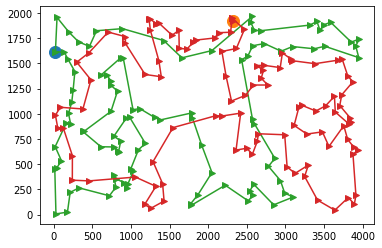

100%|██████████| 4/4 [09:12<00:00, 138.14s/it]


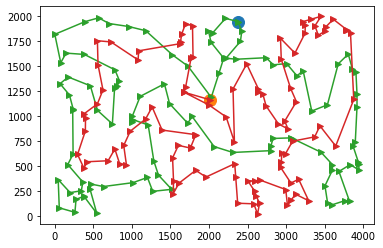

In [9]:
cyclesTable = {}
distanceTable = {}
for dataset_choice in ["kroa","krob"]:
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)    
    cyclesTable[dataset_choice]=[]
    distanceTable[dataset_choice]=[]
    for iteration in tqdm(range(4)):
        cycles,bestDist=greedy_search(dist, dataset, init_random = True, switch="change_edges")
        cyclesTable[dataset_choice].append(cycles)
        distanceTable[dataset_choice].append(bestDist)
    cycles = cyclesTable[dataset_choice][np.argmin(distanceTable[dataset_choice])]
    plt.clf()
    plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)                
    plt.plot(dataset[:,0][[*cycles[0],cycles[0][0]]], dataset[:,1][[*cycles[0],cycles[0][0]]], "->")
    plt.plot(dataset[:,0][[*cycles[1],cycles[1][1]]], dataset[:,1][[*cycles[1],cycles[1][1]]], "->")
    plt.savefig(f"1000Gredy{dataset_choice}.png")
    plt.show()
    with open(f"Greedy1000{dataset_choice}.txt", "w") as f:
        f.write(f"min:{np.min(distanceTable[dataset_choice])}, max:{np.max(distanceTable[dataset_choice])}, mean:{np.mean(distanceTable[dataset_choice])}")

In [10]:
def edgeSim(cycles1,cycles2):
    cycles1merged=list(np.concatenate([np.array(cycles1[0]),np.array([cycles1[0][0],201]),np.array(cycles1[1]),np.array([cycles1[1][0]])]))
    cycles2merged=list(np.concatenate([np.array(cycles2[0]),np.array([cycles2[0][0],202]),np.array(cycles2[1]),np.array([cycles2[1][0]])]))
    simcountr=0
    #print(cycles1merged)
    for i in range (len(cycles1merged)-1):
        #print(np.where(cycles2merged==cycles1merged[i])[0])
        if i==100 or i==101:
            #print(cycles1merged[i])
            continue
        if cycles2merged.index(cycles1merged[i])+1==cycles2merged.index(cycles1merged[i+1]):
        #if cycles1merged[i+1]==cycles2merged[np.where(cycles2merged==cycles1merged[i])[0][0]+1]:
            simcountr+=1
    return simcountr
    #cycles2merged=cycles2[0]+[202]+cycles2[1]
    #print(cycles1merged,cycles2merged)
#     for i in cycles1[0]:
        
#     cycles1[0]

In [74]:
edgeSim(cyclesTable["kroa"][0],cyclesTable["kroa"][1])

79

In [11]:
def vertexSim(cycles1,cycles2):
    z2z=0
    for v in cycles1[0]:
        if v in cycles2[0]:
            z2z+=1
    z2o=100-z2z
    if z2o>z2z:
        return 2*z2o
    else:
        return 2*z2z

In [79]:
vertexSim(cyclesTable["kroa"][0],cyclesTable["kroa"][1])

110

In [12]:
def simWithBest(cyclesTable,distanceTable):
    bestCycles=cyclesTable[np.argmin(distanceTable)]
    vertSimBest=[]
    edgeSimBest=[]
    for currCycle,currDistance in tqdm(zip(cyclesTable,distanceTable)):
#         if i==np.argmin(distanceTable):
#             continue
        vertSimBest.append((currDistance,vertexSim(currCycle,bestCycles)))
        edgeSimBest.append((currDistance,edgeSim(currCycle,bestCycles)))

    return vertSimBest,edgeSimBest

In [93]:
simWithBest(cyclesTable["kroa"],distanceTable["kroa"])

10it [00:00, 159.27it/s]


([(39381.085006167385, 100),
  (40283.174571688796, 102),
  (39226.32448512006, 108),
  (38837.585568114315, 116),
  (39118.44231016768, 104),
  (38122.50682388405, 102),
  (38297.25380060471, 114),
  (36665.56587327646, 200),
  (37597.39575136626, 102),
  (37929.32165853802, 106)],
 [(39381.085006167385, 66),
  (40283.174571688796, 70),
  (39226.32448512006, 47),
  (38837.585568114315, 65),
  (39118.44231016768, 35),
  (38122.50682388405, 37),
  (38297.25380060471, 43),
  (36665.56587327646, 198),
  (37597.39575136626, 57),
  (37929.32165853802, 55)])

In [13]:
def simAverage(cyclesTable,distanceTable):
    averageVertSim=[]
    averageEdgeSim=[]
    for firstCycle,firstDistance in tqdm(zip(cyclesTable,distanceTable)):
        vSim=[]
        eSim=[]
        for secondCycle in cyclesTable:
            vSim.append(vertexSim(firstCycle,secondCycle))
            eSim.append(edgeSim(firstCycle,secondCycle))
        averageVertSim.append((firstDistance,np.mean(vSim)))
        averageEdgeSim.append((firstDistance,np.mean(eSim)))
        
    return averageVertSim,averageEdgeSim

In [15]:
averageVertSim,averageEdgeSim=simAverage(cyclesTable["kroa"],distanceTable["kroa"])

4it [00:00, 77.31it/s]


In [36]:
def plotSim(sim,text):
    sim=sorted(sim,key=lambda sim: sim[0])
    print(sim)
    distances=[d for d,s in sim]
    similarity=[s for d,s in sim]
    correlation=np.corrcoef(distances, similarity)
    plt.title(f"{text} - Correlation: {round(correlation[0,1],3)}")
    plt.plot(distances,similarity)
    plt.savefig("_".join(text.split(" "))+".png")
    print(distances)

[(37060.95452578078, 130.0), (37710.474385316295, 131.0), (38019.711759521095, 129.5), (38660.807925794616, 132.5)]
[37060.95452578078, 37710.474385316295, 38019.711759521095, 38660.807925794616]


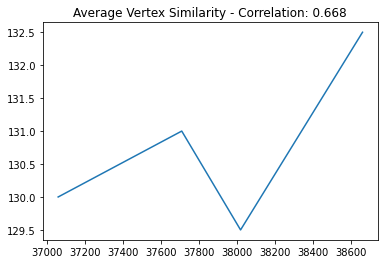

In [37]:
plotSim(averageVertSim,"Average Vertex Similarity")

4it [00:00, 260.51it/s]


[(37060.95452578078, 200), (37710.474385316295, 106), (38019.711759521095, 108), (38660.807925794616, 106)]
[37060.95452578078, 37710.474385316295, 38019.711759521095, 38660.807925794616]
[(37060.95452578078, 198), (37710.474385316295, 50), (38019.711759521095, 42), (38660.807925794616, 57)]


4it [00:00, 155.68it/s]

[37060.95452578078, 37710.474385316295, 38019.711759521095, 38660.807925794616]
[(37060.95452578078, 130.0), (37710.474385316295, 131.0), (38019.711759521095, 129.5), (38660.807925794616, 132.5)]
[37060.95452578078, 37710.474385316295, 38019.711759521095, 38660.807925794616]
[(37060.95452578078, 86.75), (37710.474385316295, 84.5), (38019.711759521095, 83.75), (38660.807925794616, 85.5)]



4it [00:00, 440.47it/s]

[37060.95452578078, 37710.474385316295, 38019.711759521095, 38660.807925794616]
[(37516.83348496791, 200), (38060.03546035003, 104), (38262.4193246207, 102), (40486.650198188465, 104)]



4it [00:00, 119.94it/s]

[37516.83348496791, 38060.03546035003, 38262.4193246207, 40486.650198188465]
[(37516.83348496791, 198), (38060.03546035003, 76), (38262.4193246207, 54), (40486.650198188465, 39)]
[37516.83348496791, 38060.03546035003, 38262.4193246207, 40486.650198188465]
[(37516.83348496791, 127.5), (38060.03546035003, 131.5), (38262.4193246207, 127.0), (40486.650198188465, 131.0)]


[37516.83348496791, 38060.03546035003, 38262.4193246207, 40486.650198188465]
[(37516.83348496791, 92.0), (38060.03546035003, 92.0), (38262.4193246207, 91.75), (40486.650198188465, 81.75)]
[37516.83348496791, 38060.03546035003, 38262.4193246207, 40486.650198188465]


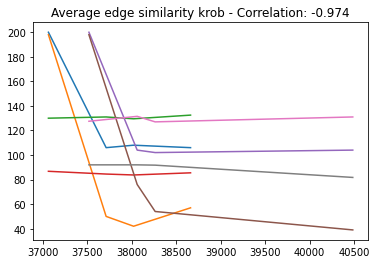

In [40]:
for dataset_choice in ["kroa","krob"]:
    vertSimBest,edgeSimBest=simWithBest(cyclesTable[dataset_choice],distanceTable[dataset_choice])
    plotSim(vertSimBest,f"Vertex similarity comparing best {dataset_choice}")
    plotSim(edgeSimBest,f"Edge similarity comparing best {dataset_choice}")
    averageVertSim,averageEdgeSim=simAverage(cyclesTable[dataset_choice],distanceTable[dataset_choice])
    plotSim(averageVertSim,f"Average vertex similarity {dataset_choice}")
    plotSim(averageEdgeSim,f"Average edge similarity {dataset_choice}")